In [74]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts

import pathlib
import argparse
import scipy

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)

## runtime params

In [82]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = 0.8*sig_xsec_default*lumi/sig_gen_events #20% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0005265674601680545


In [44]:
xsecs_sig   = [0,20,40,60,80,100] # signal cross sections
file_name = 'histograms_injSig_PDinj_NA3p5.root'
quants = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quants_inv = [round((1.-q),2) for q in quants] # invert quantiles to [1.0 0.9, 0.7, 0.5, 0.3, 0.1, 0.01]

In [45]:
# efficiencies
quants_tmp = np.asarray(quants+[1.])
effs = (quants_tmp)[1:] - (quants_tmp)[:-1]
effs = effs[1:]/effs[0] # scale down instead of up (apply to template quantile)

In [46]:
effs

array([0.66666667, 0.66666667, 0.66666667, 0.3       , 0.03333333])

In [78]:
ae_run_n = 113
qr_run_n, qr_model_str = 4, 'poly'
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_ids = ['qcdSigAllTestReco', 'GtoWW35naReco']
sample_id_qcd = sample_ids[0]
sample_id_sig = sample_ids[1]
template_q_idx = 0

In [81]:
bin_edges_dijet = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float')

n_bins = len(bin_edges_dijet)-1
max_bin = bin_edges_dijet[-1]
min_bin = bin_edges_dijet[0]

## read histogram data

In [47]:
def read_root_hist_data(file_name):
    
    hist_data = {}
    ff = rt.TFile.Open(file_name,'r')

    # read bins from template quantile
    dat = ff.Get('data_acc_{}fb_q{}p'.format(0,int(100))); dat.SetDirectory(0);
    bin_centers = np.asarray([dat.GetXaxis().GetBinCenter(j) for j in range(1,dat.GetNbinsX()+1)])

    # for each quantile
    for i, quant in enumerate(quants):

        hist_data_quant = {}
        q_key = quants_inv[i]*100

        # for each signal injection
        for xsec in xsecs_sig:

            dat = ff.Get('data_acc_{}fb_q{}p'.format(xsec,int(q_key))); dat.SetDirectory(0);
            yy = np.asarray([dat.GetBinContent(j) for j in range(1,dat.GetNbinsX()+1)])

            hist_data_quant[xsec] = yy

        hist_data[quant] = hist_data_quant
        
    return bin_centers, hist_data

In [ ]:
def read_raw_selection_data():
    
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
    paths.extend_in_path_data(path_ext_dict)

    samples = {}

    for sample_id in sample_ids:
        samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles)
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles)
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    mjj_max_qcd = max([max(m) for m in mjj_vals_qcd])
    mjj_max_sig = max([max(m) for m in mjj_vals_sig])
    bin_edges_dijet.append(max(mjj_max_qcd,mjj_max_sig))
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[template_q_idx:], quants[template_q_idx:]):
        counts, * = plt.hist(mjj, bins=bin_edges_dijet)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[template_q_idx:], quants[template_q_idx:]):
        counts, * = plt.hist(mjj, bins=bin_edges_dijet)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quants:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            sig_inj = 
            
            
            
        histos_data_inj[quant] = histos_data_inj_quant
            
            
    

In [48]:
bin_centers, hist_data = read_root_hist_data(file_name)

## plot histograms

/cvmfs/sft.cern.ch/lcg/views/LCG_96bpython3/x86_64-centos7-gcc9-opt/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


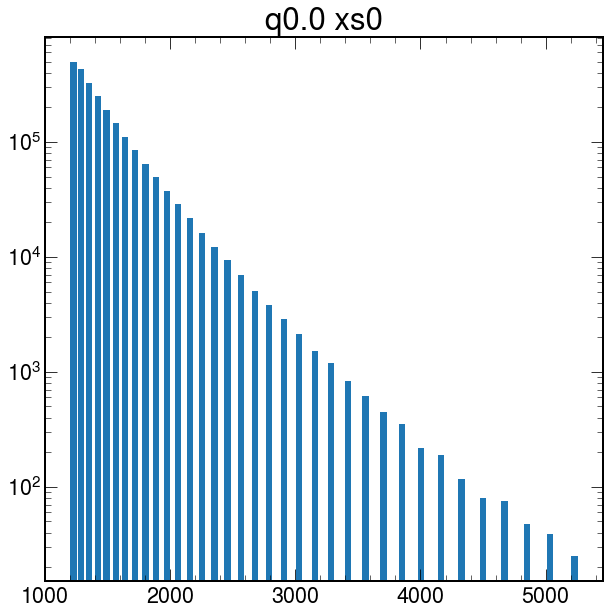

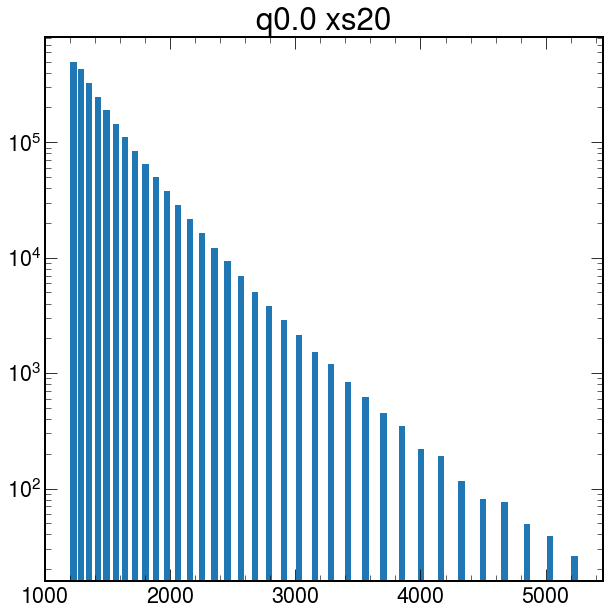

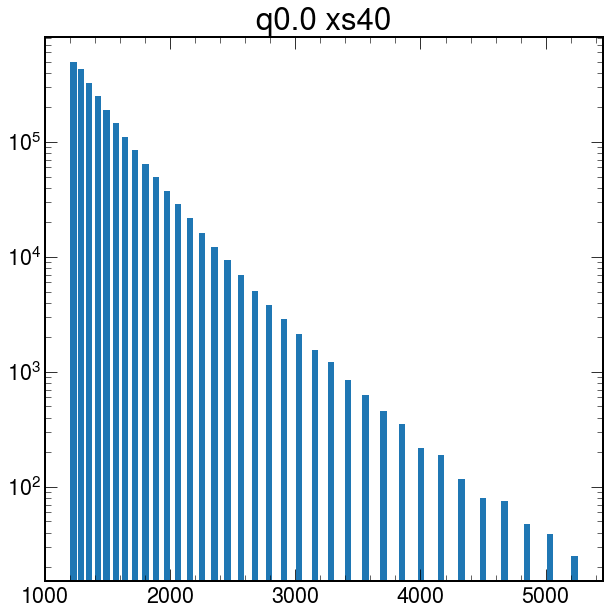

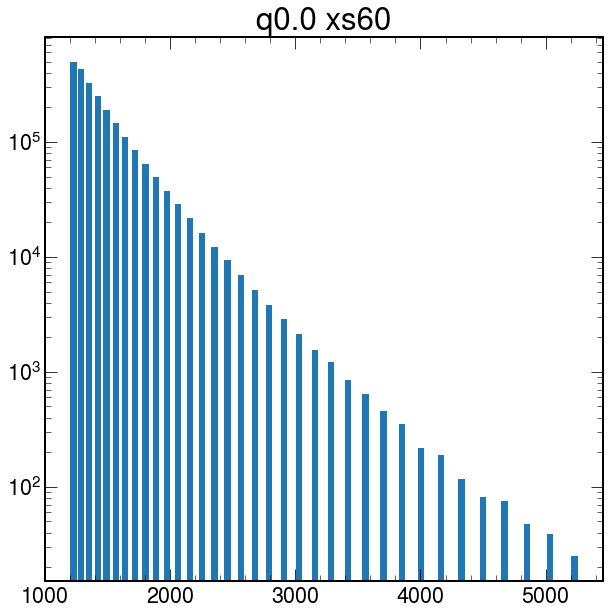

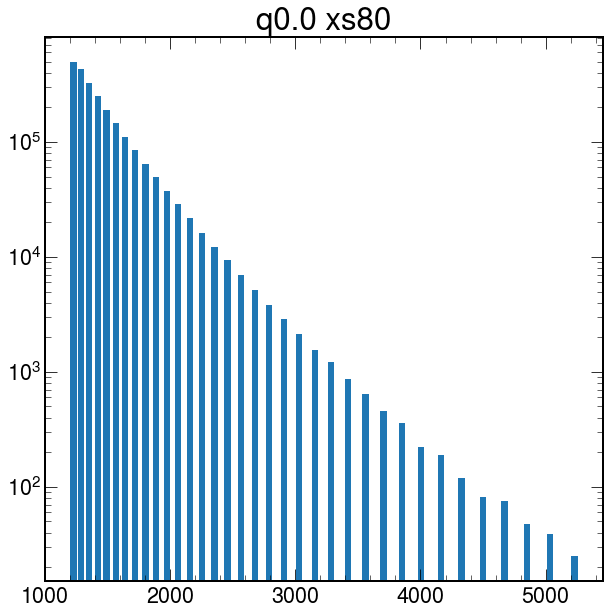

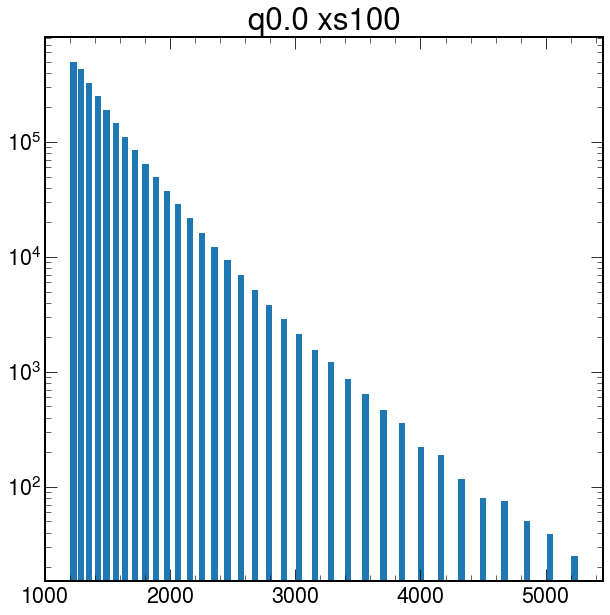

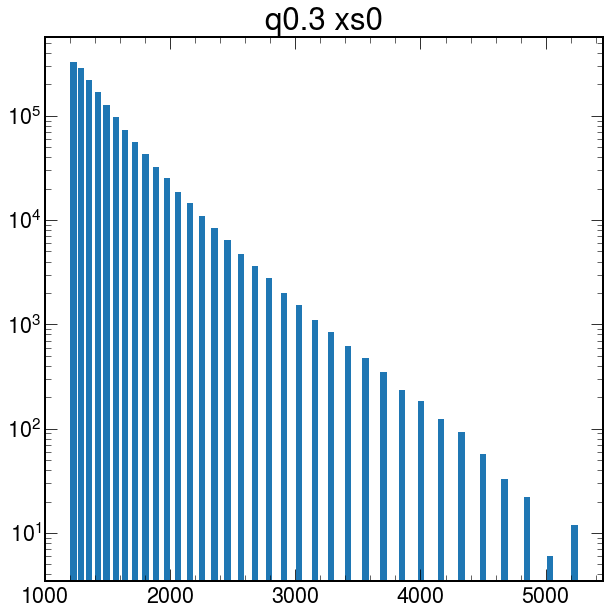

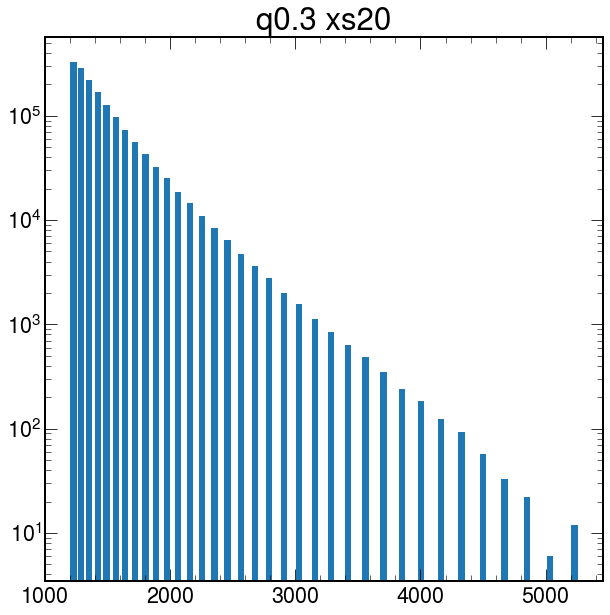

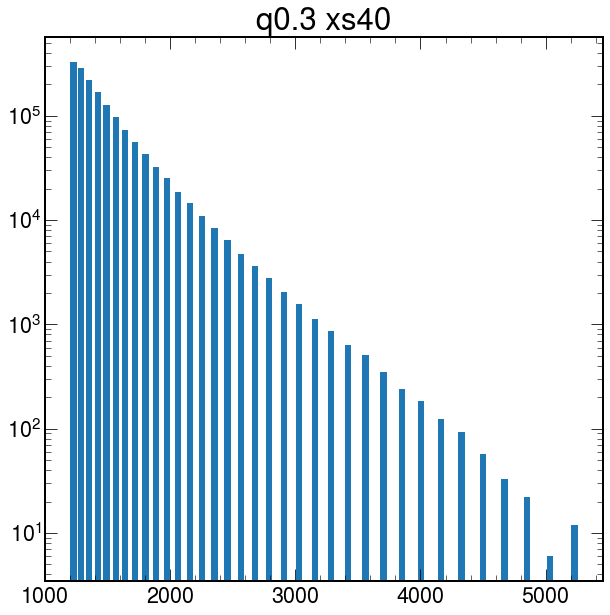

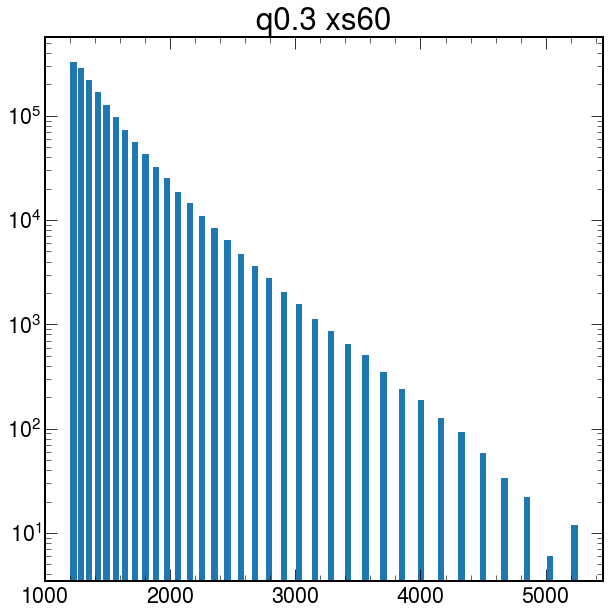

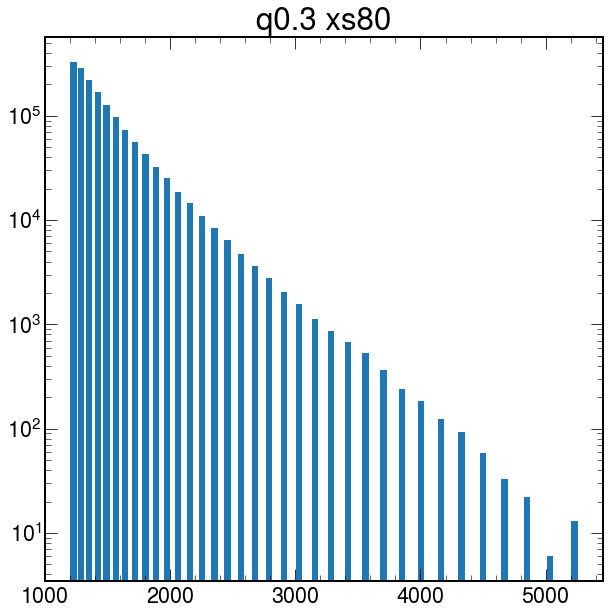

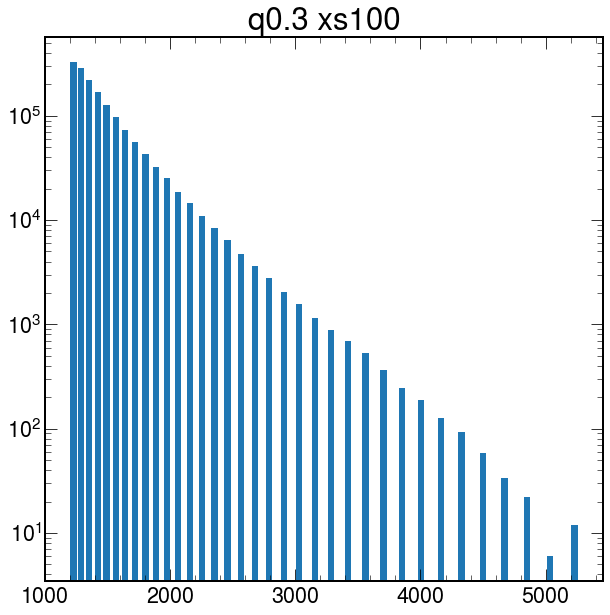

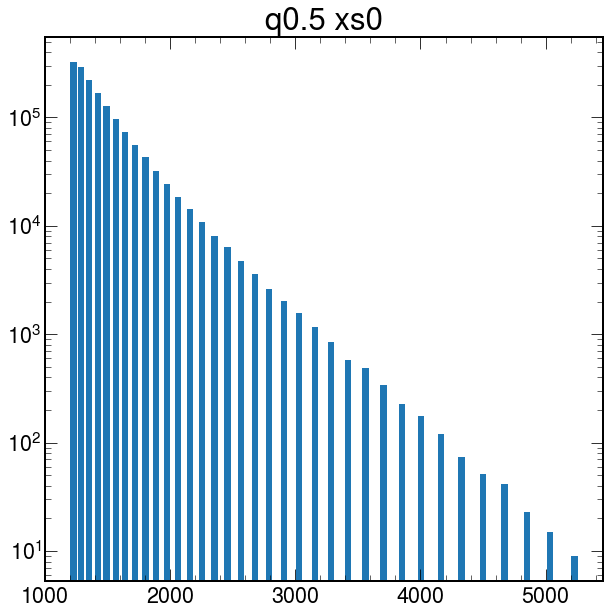

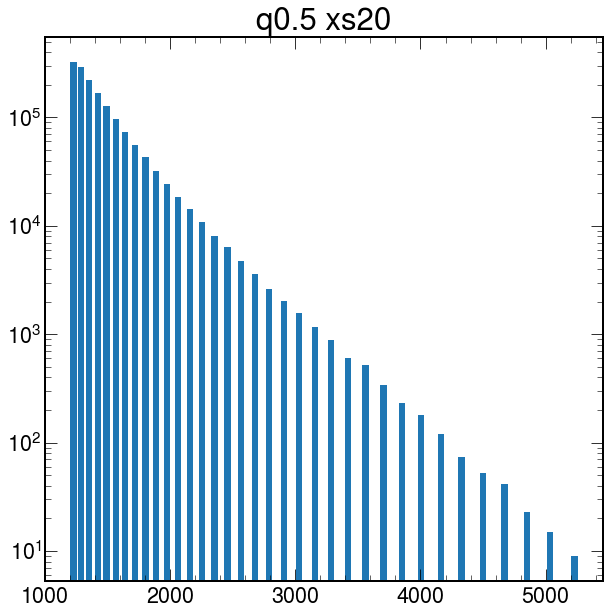

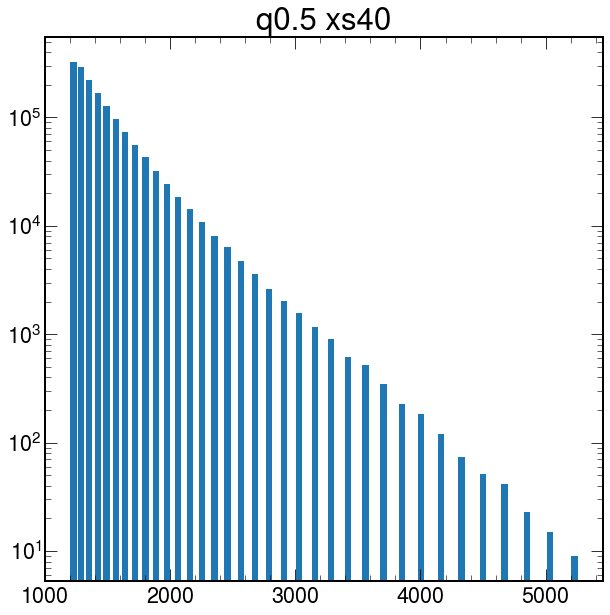

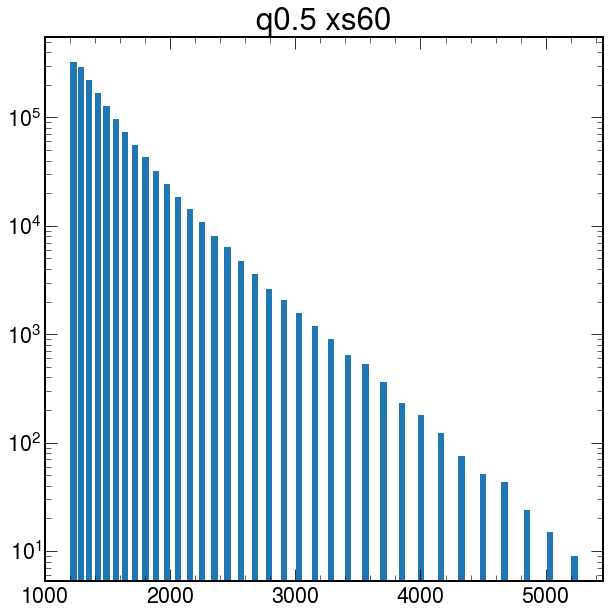

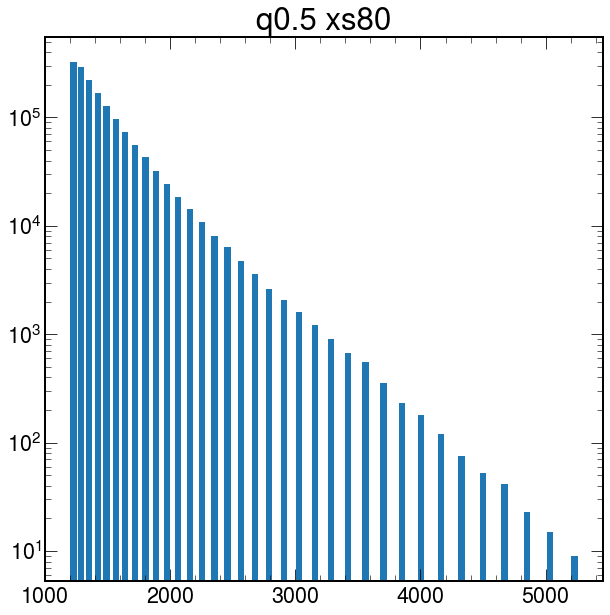

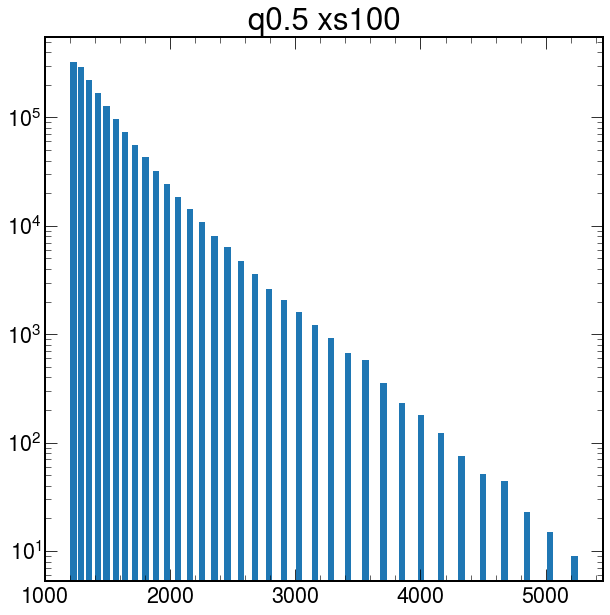

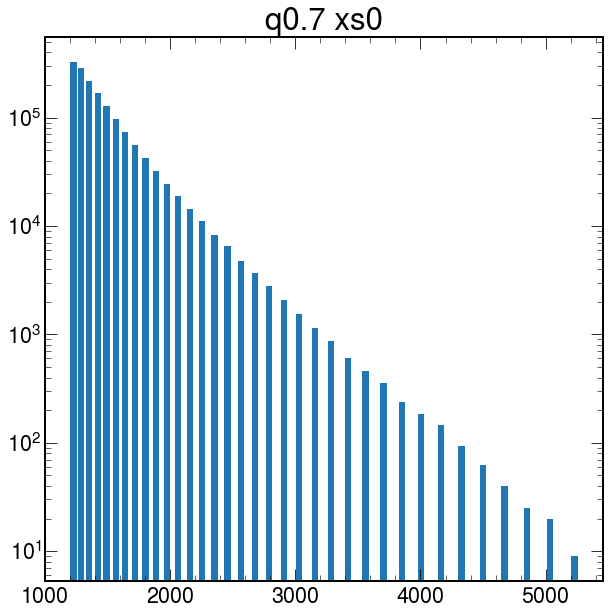

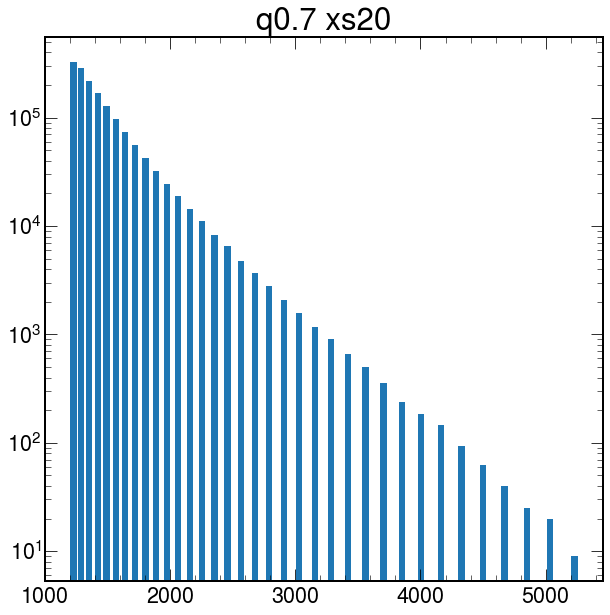

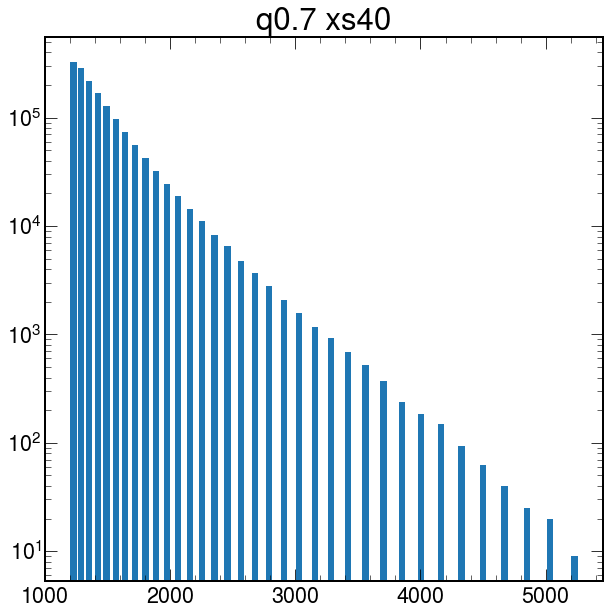

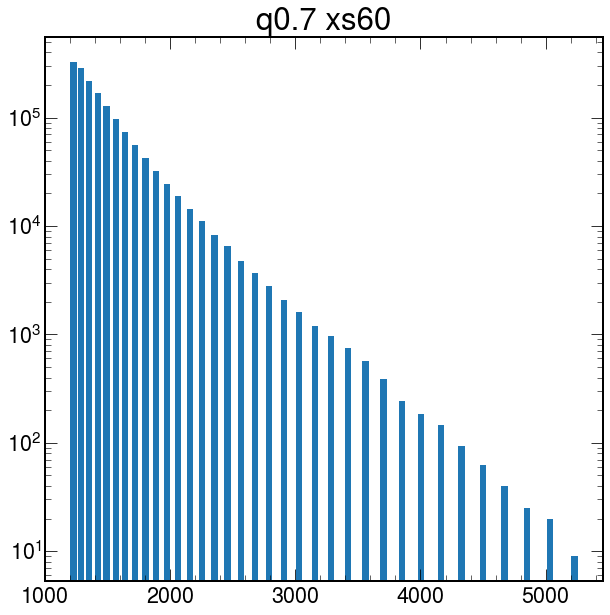

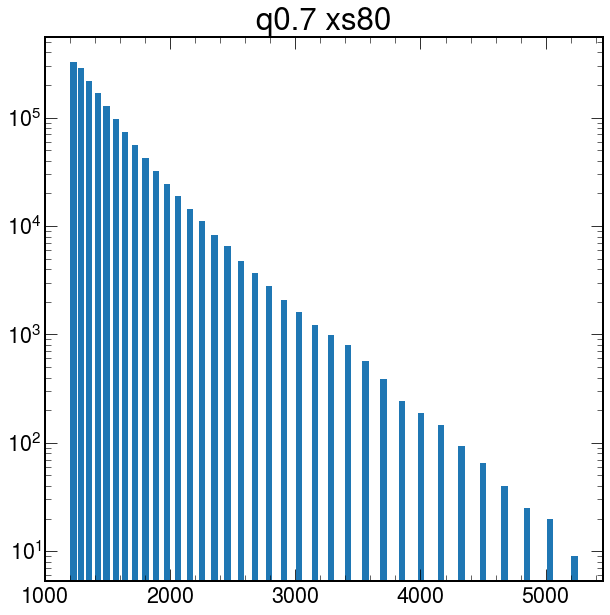

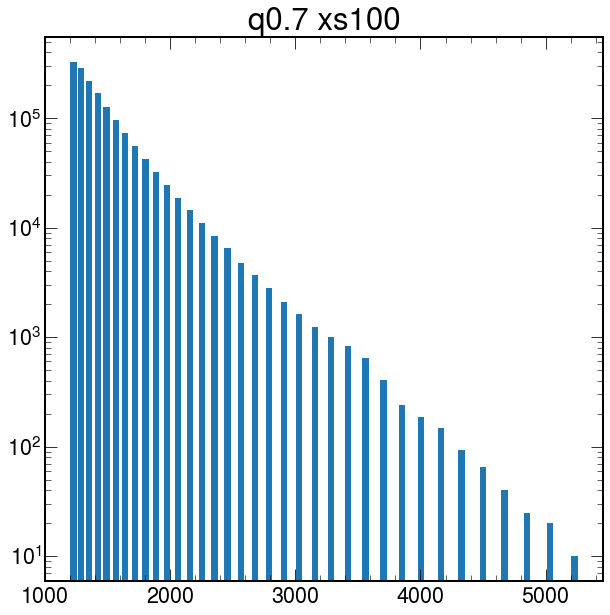

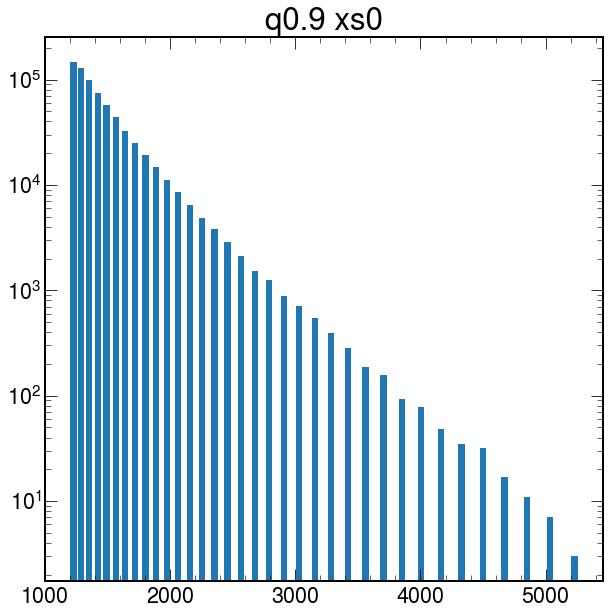

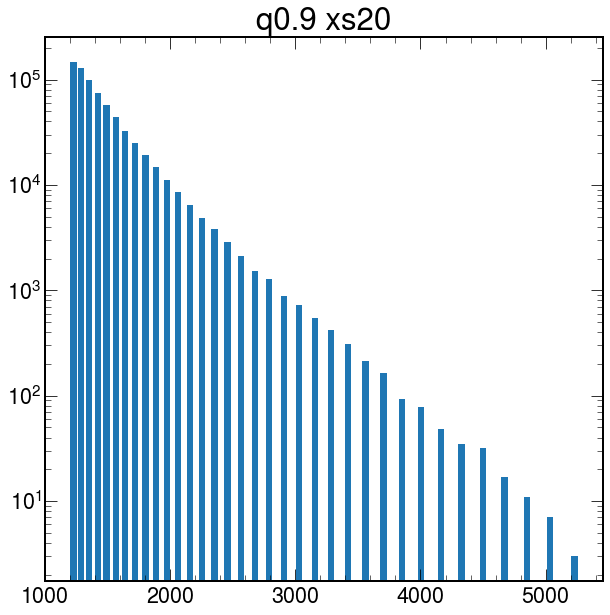

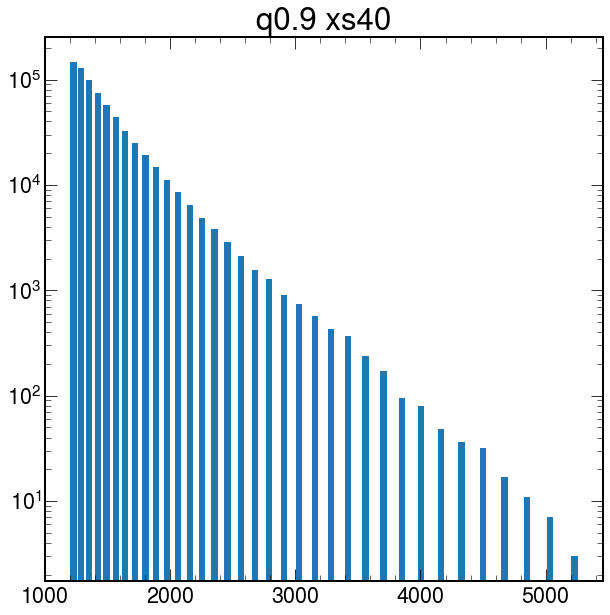

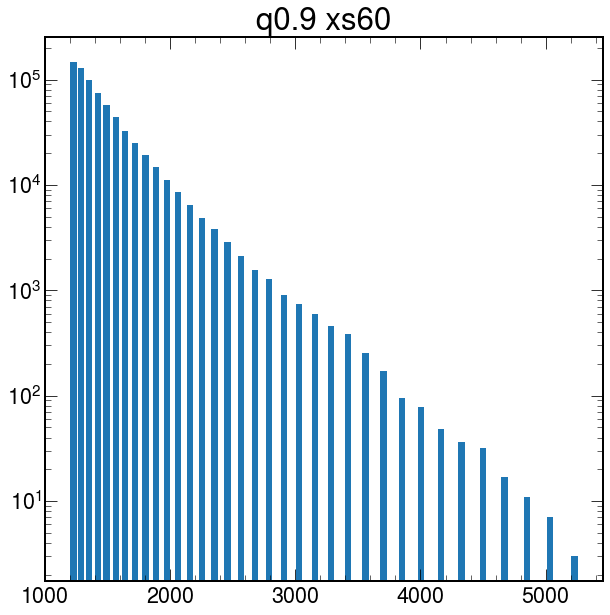

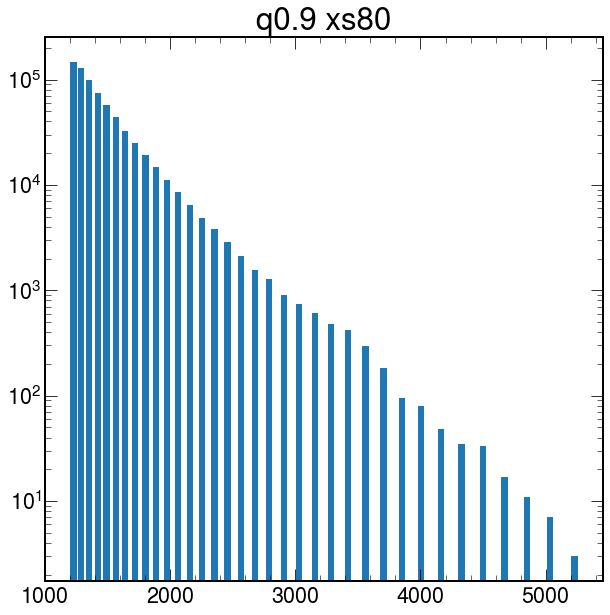

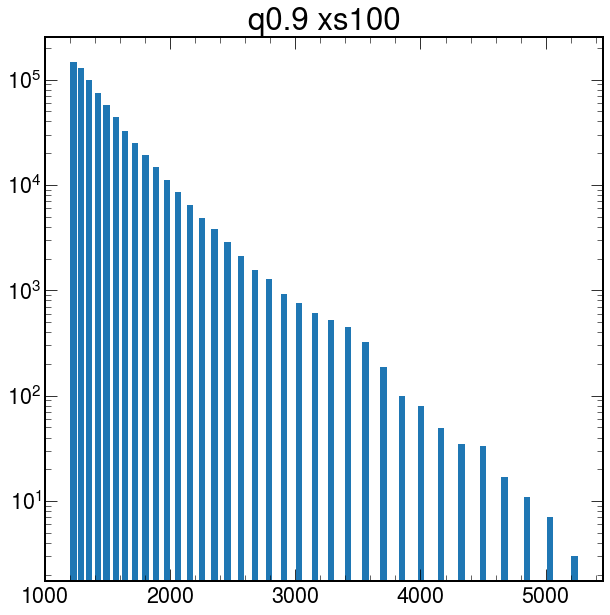

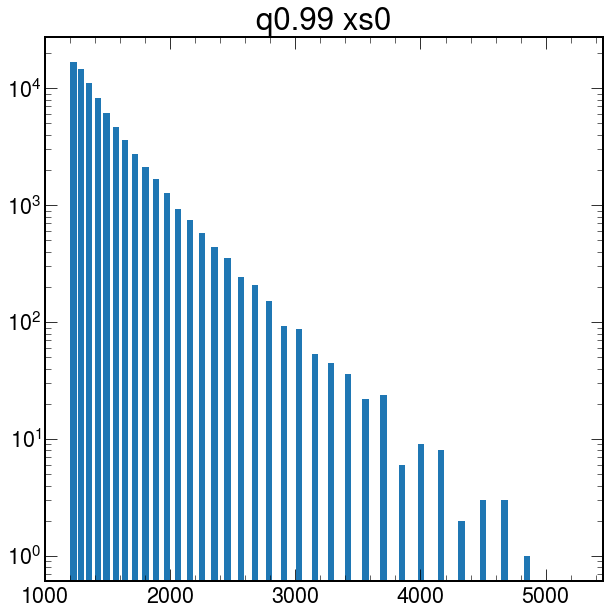

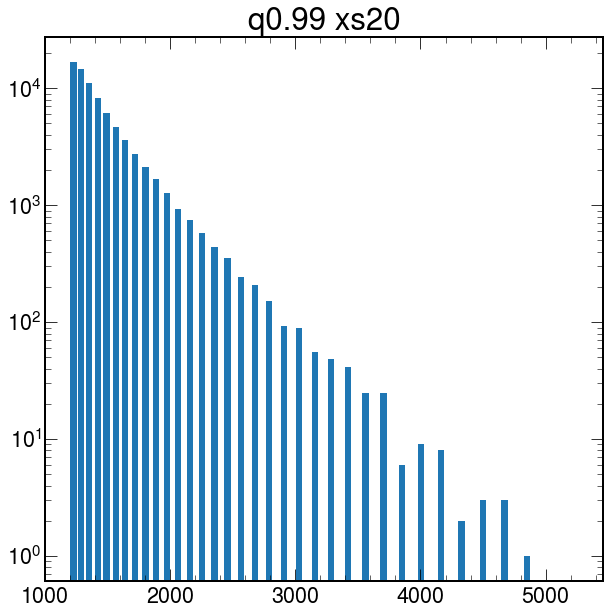

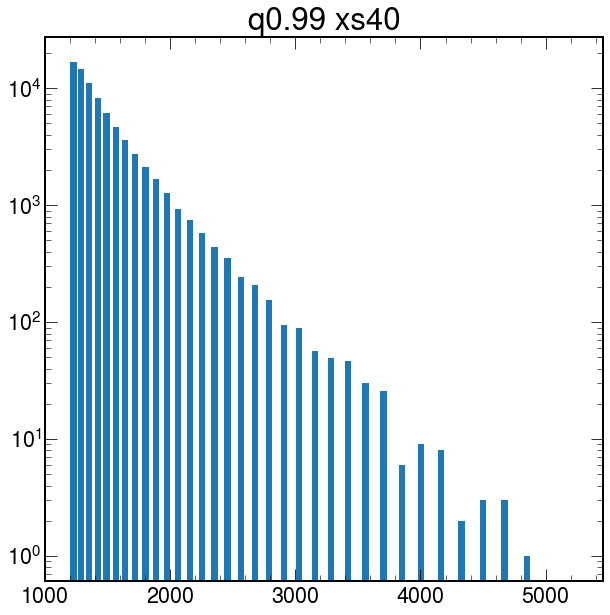

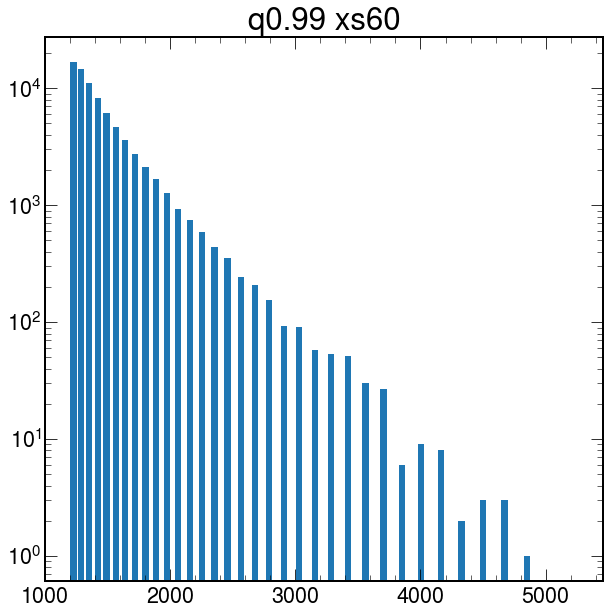

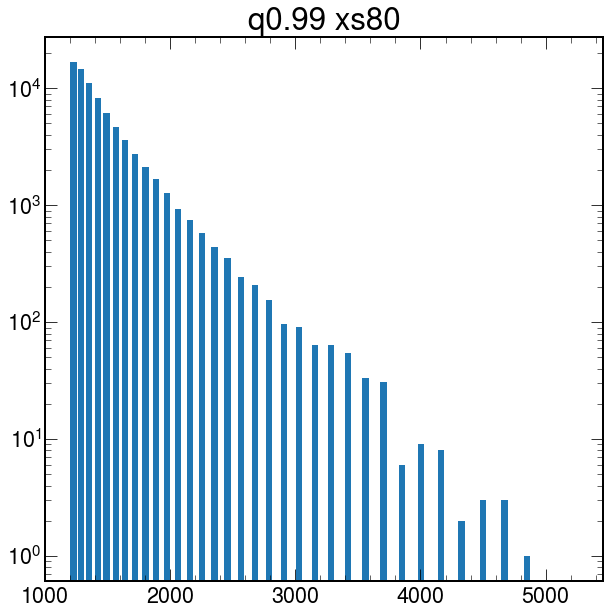

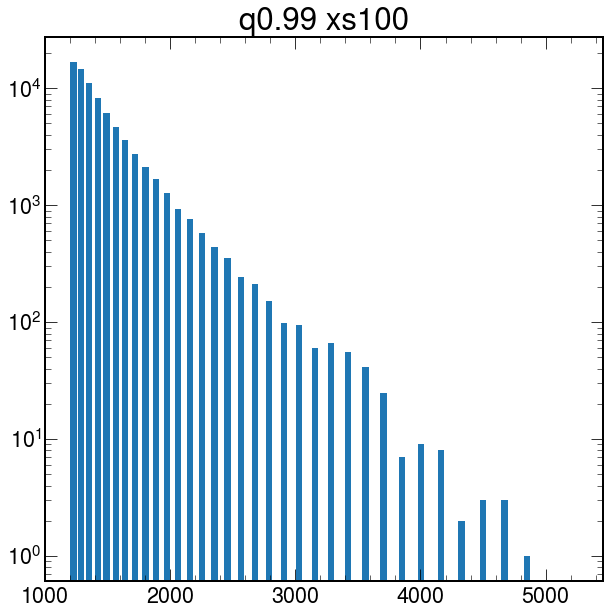

In [49]:
for quant in quants:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        plt.figure()
        plt.bar(bin_centers, yy, width=50, log=True)
        plt.title('q{} xs{}'.format(quant, xsec))

# Chi Square test

In [50]:
quant_tmplt = quants[0]
dat_tmplt = hist_data[quant_tmplt]

In [51]:
for quant, eff in zip(quants[1:], effs):
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0) for xsec in xsecs_sig]
    print('pvals for quantile {}'.format(quant))
    print(xsecs_sig)
    print(p_vals)

pvals for quantile 0.3
[0, 20, 40, 60, 80, 100]
[Power_divergenceResult(statistic=259.5313542633959, pvalue=1.548969009073438e-36), Power_divergenceResult(statistic=263.5298293600916, pvalue=2.673721226253749e-37), Power_divergenceResult(statistic=271.7882675693593, pvalue=7.021790050067094e-39), Power_divergenceResult(statistic=273.6150527914883, pvalue=3.132818643921429e-39), Power_divergenceResult(statistic=286.5723957939151, pvalue=1.0028750086153668e-41), Power_divergenceResult(statistic=305.97692539770406, pvalue=1.735739684772414e-45)]
pvals for quantile 0.5
[0, 20, 40, 60, 80, 100]
[Power_divergenceResult(statistic=408.94078200669, pvalue=7.661232627231875e-66), Power_divergenceResult(statistic=431.0718929050739, pvalue=2.772997740330376e-70), Power_divergenceResult(statistic=436.84654567157, pvalue=1.9099040671724605e-71), Power_divergenceResult(statistic=441.293224125782, pvalue=2.4291765942750046e-72), Power_divergenceResult(statistic=470.72001040740054, pvalue=2.76683811750

In [67]:
quant = 0.7
xsec = 0
eff = 0.2/0.3 # 30% bottom quantile vs 20% 0.7-0.9 quantile

In [68]:
eff

0.6666666666666667

In [69]:
# observed
hist_data[quant][xsec]

array([3.27059e+05, 2.89290e+05, 2.19721e+05, 1.69004e+05, 1.26865e+05,
       9.70570e+04, 7.31420e+04, 5.54140e+04, 4.22470e+04, 3.23390e+04,
       2.45090e+04, 1.87800e+04, 1.44580e+04, 1.10270e+04, 8.31400e+03,
       6.55300e+03, 4.75100e+03, 3.65100e+03, 2.77600e+03, 2.06100e+03,
       1.55500e+03, 1.13600e+03, 8.68000e+02, 6.11000e+02, 4.60000e+02,
       3.54000e+02, 2.37000e+02, 1.84000e+02, 1.47000e+02, 9.30000e+01,
       6.30000e+01, 4.00000e+01, 2.50000e+01, 2.00000e+01, 9.00000e+00])

In [70]:
# expected
hist_data[0.0][xsec]*eff

array([3.30868667e+05, 2.88994000e+05, 2.17284667e+05, 1.65885333e+05,
       1.25869333e+05, 9.67606667e+04, 7.38453333e+04, 5.65160000e+04,
       4.31266667e+04, 3.30646667e+04, 2.50846667e+04, 1.91113333e+04,
       1.43820000e+04, 1.08473333e+04, 8.12666667e+03, 6.26400000e+03,
       4.59733333e+03, 3.39133333e+03, 2.52800000e+03, 1.90933333e+03,
       1.42000000e+03, 1.01800000e+03, 7.98000000e+02, 5.57333333e+02,
       4.09333333e+02, 3.00666667e+02, 2.33333333e+02, 1.45333333e+02,
       1.26666667e+02, 7.80000000e+01, 5.33333333e+01, 5.06666667e+01,
       3.20000000e+01, 2.60000000e+01, 1.66666667e+01])

In [71]:
statistic = 0
for e, o in zip(hist_data[0.0][xsec]*eff, hist_data[quant][xsec]):
    print('obs {}, exp {}, stat {}'.format(o,e,(o-e)**2/e))
    statistic += (o-e)**2/e

obs 327059.0, exp 330868.6666666667, stat 43.86501827848489
obs 289290.0, exp 288994.00000000006, stat 0.303175844481081
obs 219721.0, exp 217284.6666666667, stat 27.317712759809787
obs 169004.0, exp 165885.33333333334, stat 58.6313544563577
obs 126865.0, exp 125869.33333333334, stat 7.8760416445977715
obs 97057.0, exp 96760.66666666667, stat 0.9075324454610506
obs 73142.0, exp 73845.33333333334, stat 6.698836005585432
obs 55414.0, exp 56516.00000000001, stat 21.487791068016417
obs 42247.0, exp 43126.66666666667, stat 17.942806719225217
obs 32339.0, exp 33064.66666666667, stat 15.92612792440424
obs 24509.0, exp 25084.666666666668, stat 13.210943382854566
obs 18780.0, exp 19111.333333333336, stat 5.744328554319219
obs 14458.0, exp 14382.000000000002, stat 0.4016131275204925
obs 11027.0, exp 10847.333333333334, stat 2.9758568414151765
obs 8314.0, exp 8126.666666666668, stat 4.318348372983263
obs 6553.0, exp 6264.000000000001, stat 13.33349297573427
obs 4751.0, exp 4597.333333333334, stat

In [72]:
statistic

382.8222427195808

In [58]:
scipy.stats.chisquare(f_obs=hist_data[quant][xsec], f_exp=hist_data[0.0][xsec]*eff, axis=0)

Power_divergenceResult(statistic=259.5313542633959, pvalue=1.548969009073438e-36)

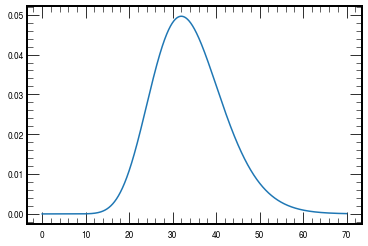

In [21]:
from scipy.stats import chi2
x = np.arange(0, 70, 0.001)
plt.plot(x, chi2.pdf(x, df=len(hist_data[quant][xsec])-1)) # df = num-observed - 1